### The Happiness Project
* 

In [3]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#import plotly.express as px

import gmaps
import requests
import json


from scipy.stats import linregress

# Import API key
# from api_keys import weather_api_key
# from api_keys import g_key

In [4]:
# Import World Happiness Report Data 2021
raw_happiness_df = pd.read_csv("Data/world-happiness-report-2021.csv")

# Rename columns
raw_happiness_df = raw_happiness_df.rename(columns={'Country name': 'Country', 
                                                'Regional indicator': 'Region',
                                                'Ladder score': 'Happiness Score',
                                                'Social support': 'Social Support',                                                    
                                                'Logged GDP per capita': 'GDP per Capita',
                                                'Healthy life expectancy': 'Life Expectancy',
                                                'Freedom to make life choices': 'Freedom',
                                                'Perceptions of corruption': 'Corruption'})

# Drop columns not needed
happiness_df = raw_happiness_df.drop(columns=['Standard error of ladder score', 
                                              'upperwhisker', 
                                              'lowerwhisker',
                                              'Ladder score in Dystopia',
                                              'Explained by: Log GDP per capita',
                                              'Explained by: Social support',
                                              'Explained by: Healthy life expectancy',
                                              'Explained by: Freedom to make life choices',
                                              'Explained by: Generosity',
                                              'Explained by: Perceptions of corruption',
                                              'Dystopia + residual'])
# Show preview of DataFrame
happiness_df

,Country,Region,Happiness Score,GDP per Capita,Social Support,Life Expectancy,Freedom,Generosity,Corruption
0,Finland,Western Europe,7.842,10.775,0.954,72.000,0.949,-0.098,0.186
1,Denmark,Western Europe,7.620,10.933,0.954,72.700,0.946,0.030,0.179
2,Switzerland,Western Europe,7.571,11.117,0.942,74.400,0.919,0.025,0.292
3,Iceland,Western Europe,7.554,10.878,0.983,73.000,0.955,0.160,0.673
4,Netherlands,Western Europe,7.464,10.932,0.942,72.400,0.913,0.175,0.338
...,...,...,...,...,...,...,...,...,...
144,Lesotho,Sub-Saharan Africa,3.512,7.926,0.787,48.700,0.715,-0.131,0.915
145,Botswana,Sub-Saharan Africa,3.467,9.782,0.784,59.269,0.824,-0.246,0.801
146,Rwanda,Sub-Saharan Africa,3.415,7.676,0.552,61.400,0.897,0.061,0.167
147,Zimbabwe,Sub-Saharan Africa,3.145,7.943,0.750,56.201,0.677,-0.047,0.821


In [5]:
# Select data for happiness map from happiness_df
happiness_map_data = happiness_df[['Country', 'Happiness Score']]

# Set happiness map parameters
fig = px.choropleth(happiness_map_data, 
                     locations="Country", 
                     locationmode = "country names",
                     color = "Happiness Score",
                     hover_name = "Country",
                     color_continuous_scale = px.colors.sequential.Plasma)

# Show map
fig.show()

NameError: name 'px' is not defined

### Things to consider;
Correlation / Causation. What makes us Happy vs. What can result from Happiness..

The r-value is 0.7897596965098932


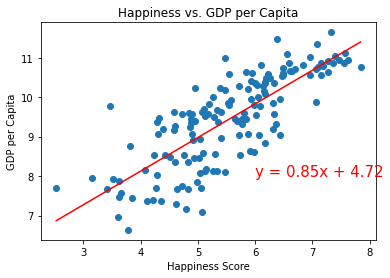

In [4]:
# Set values for x and y axis
x_axis = happiness_df['Happiness Score']
y_axis = happiness_df['GDP per Capita']

# Create line plot
plt.scatter(x_axis, y_axis)

# Create linear regression equation and line to plot
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(6,8),fontsize=15,color="red")

# Add title and labels to line plot
plt.title('Happiness vs. GDP per Capita')
plt.xlabel('Happiness Score')
plt.ylabel('GDP per Capita')          

# Save plotted figure as .png
plt.savefig("images/Happiness_GDP_per_capita.png")

# Show line plot
print(f"The r-value is {rvalue}")
plt.show()

The r-value is 0.7568876453635


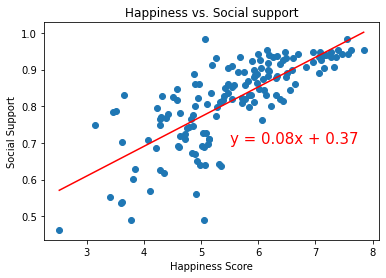

In [5]:
# Set values for x and y axis
x_axis = happiness_df['Happiness Score']
y_axis = happiness_df['Social Support']

# Create line plot
plt.scatter(x_axis, y_axis)

# Create linear regression equation and line to plot
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(5.5,0.7),fontsize=15,color="red")

# Add title and labels to line plot
plt.title('Happiness vs. Social support')
plt.xlabel('Happiness Score')
plt.ylabel('Social Support')

# Save plotted figure as .png
plt.savefig("images/Happiness_Social_Support.png")
           
# Show line plot
print(f"The r-value is {rvalue}")
plt.show()

The r-value is 0.7680994550105201


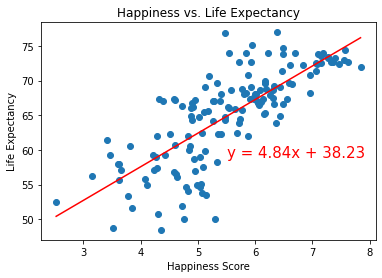

In [6]:
# Set values for x and y axis
x_axis = happiness_df['Happiness Score']
y_axis = happiness_df['Life Expectancy']

# Create line plot
plt.scatter(x_axis, y_axis)

# Create linear regression equation and line to plot
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(5.5,59),fontsize=15,color="red")

# Add title and labels to line plot
plt.title('Happiness vs. Life Expectancy')
plt.xlabel('Happiness Score')
plt.ylabel('Life Expectancy')          

# Save plotted figure as .png
plt.savefig("images/Happiness_Life_Expectancy.png")

# Show line plot
print(f"The r-value is {rvalue}")
plt.show()

The r-value is 0.6077530656580241


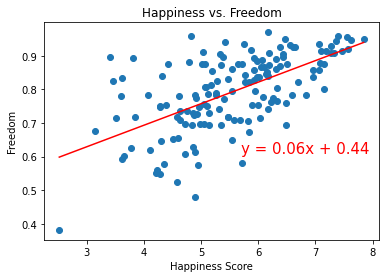

In [7]:
# Set values for x and y axis
x_axis = happiness_df['Happiness Score']
y_axis = happiness_df['Freedom']

# Create line plot
plt.scatter(x_axis, y_axis)

# Create linear regression equation and line to plot
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(5.7,0.61),fontsize=15,color="red")

# Add title and labels to line plot
plt.title('Happiness vs. Freedom')
plt.xlabel('Happiness Score')
plt.ylabel('Freedom')          

# Save plotted figure as .png
plt.savefig("images/Happiness_Freedom.png")

# Show line plot
print(f"The r-value is {rvalue}")
plt.show()

The r-value is -0.017799276922640783


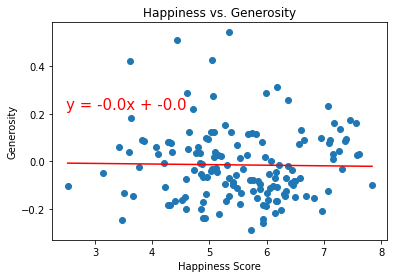

In [8]:
# Set values for x and y axis
x_axis = happiness_df['Happiness Score']
y_axis = happiness_df['Generosity']

# Create line plot
plt.scatter(x_axis, y_axis)

# Create linear regression equation and line to plot
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(2.5,0.22),fontsize=15,color="red")

# Add title and labels to line plot
plt.title('Happiness vs. Generosity')
plt.xlabel('Happiness Score')
plt.ylabel('Generosity')          

# Save plotted figure as .png
plt.savefig("images/Happiness_Generosity.png")

# Show line plot
print(f"The r-value is {rvalue}")
plt.show()

The r-value is -0.42113999673857816


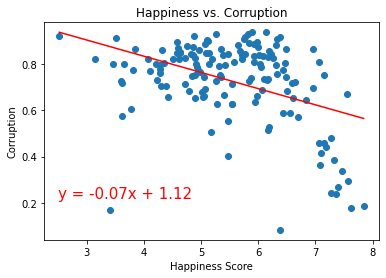

In [9]:
# Set values for x and y axis
x_axis = happiness_df['Happiness Score']
y_axis = happiness_df['Corruption']

# Create line plot
plt.scatter(x_axis, y_axis)

# Create linear regression equation and line to plot
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(2.5,0.22),fontsize=15,color="red")

# Add title and labels to line plot
plt.title('Happiness vs. Corruption')
plt.xlabel('Happiness Score')
plt.ylabel('Corruption')          

# Save plotted figure as .png
plt.savefig("images/Happiness_Corruption.png")

# Show line plot
print(f"The r-value is {rvalue}")
plt.show()

In [10]:
# Read in GDP per Capita .csv file
GDP_per_capita_df = pd.read_csv("Data/World_GDP_per_capita_1960-2019.csv")

# Reduce dataframe to only show 2019 GDP per Capita
GDP_per_capita_2019_df = GDP_per_capita_df[['Country Name', '2019']]

# Rename columns
GDP_per_capita_2019_df = GDP_per_capita_2019_df.rename(columns={'Country Name': 'Country',
                                                                '2019': '2019 GDP per Capita'})

# GDP_per_capita_df = GDP_per_capita_df.dropna()

# Show dataframe preview
GDP_per_capita_2019_df.head()

,Country,2019 GDP per Capita
0,Aruba,NaN
1,Afghanistan,507.103432
2,Angola,2790.726615
3,Albania,5353.244856
4,Andorra,40886.391160


In [11]:
# Read in GDP .csv file
GDP_df = pd.read_csv("Data/World_GDP_1960-2019.csv")

# Reduce dataframe to only show 2019 GDP per Capita
GDP_2019_df = GDP_df[['Country Name', '2019']]

# Rename columns
GDP_2019_df = GDP_2019_df.rename(columns={'Country Name': 'Country',
                                          '2019': '2019 GDP'})

# GDP_2019_df = GDP_2019_df.dropna()

# Show dataframe preview
GDP_2019_df.head()

,Country,2019 GDP
0,Aruba,NaN
1,Afghanistan,1.929110e+10
2,Angola,8.881570e+10
3,Albania,1.527918e+10
4,Andorra,3.154058e+09


In [12]:
# Merge happiness, 2019 GDP per Capita and 2019 GDP dataframes
happiness_GDP_2019_df = pd.merge(happiness_df, GDP_per_capita_2019_df, how='inner', on="Country") 
happiness_GDP_2019_df = pd.merge(happiness_GDP_2019_df, GDP_2019_df, how='inner', on="Country") 

# Show dataframe preview
happiness_GDP_2019_df.head()

,Country,Region,Happiness Score,GDP per Capita,Social Support,Life Expectancy,Freedom,Generosity,Corruption,2019 GDP per Capita,2019 GDP
0,Finland,Western Europe,7.842,10.775,0.954,72.0,0.949,-0.098,0.186,48782.78848,2.692960e+11
1,Denmark,Western Europe,7.620,10.933,0.954,72.7,0.946,0.030,0.179,60170.34264,3.501040e+11
2,Switzerland,Western Europe,7.571,11.117,0.942,74.4,0.919,0.025,0.292,81993.72713,7.030820e+11
3,Iceland,Western Europe,7.554,10.878,0.983,73.0,0.955,0.160,0.673,66944.83308,2.418804e+10
4,Netherlands,Western Europe,7.464,10.932,0.942,72.4,0.913,0.175,0.338,52331.31673,9.070510e+11


The r-value is nan


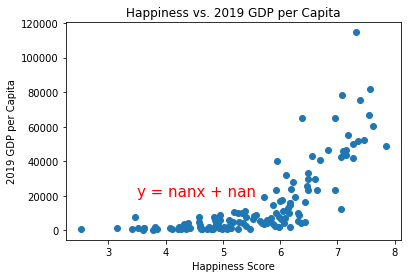

In [13]:
# Set values for x and y axis
x_axis = happiness_GDP_2019_df['Happiness Score']
y_axis = happiness_GDP_2019_df['2019 GDP per Capita']

# Create line plot
plt.scatter(x_axis, y_axis)

# Create linear regression equation and line to plot
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(3.5,20000),fontsize=15,color="red")

# Add title and labels to line plot
plt.title('Happiness vs. 2019 GDP per Capita')
plt.xlabel('Happiness Score')
plt.ylabel('2019 GDP per Capita')          

# Save plotted figure as .png
plt.savefig("images/Happiness_2019_GDP_per_Capita.png")

# Show line plot
print(f"The r-value is {rvalue}")
plt.show()

The r-value is nan


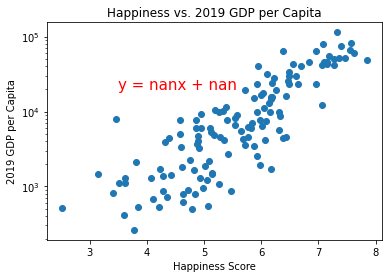

In [14]:
# Cr-create previous plot but with a logarithmic scale on the y-axis
fig = plt.scatter(x_axis, y_axis)
ax = plt.gca()
ax.set_yscale('log')

# Create linear regression equation and line to plot
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(3.5,20000),fontsize=15,color="red")

# Add title and labels to line plot
plt.title('Happiness vs. 2019 GDP per Capita')
plt.xlabel('Happiness Score')
plt.ylabel('2019 GDP per Capita')          

# Save plotted figure as .png
plt.savefig("images/Happiness_2019_GDP_per_Capita.png")

# Show line plot
print(f"The r-value is {rvalue}")
plt.show()

The r-value is nan


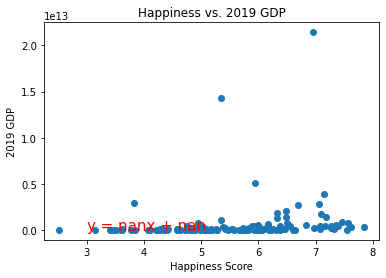

In [15]:
# Set values for x and y axis
x_axis = happiness_GDP_2019_df['Happiness Score']
y_axis = happiness_GDP_2019_df['2019 GDP']

# Create line plot
plt.scatter(x_axis, y_axis)

# Create linear regression equation and line to plot
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(3,0.5),fontsize=15,color="red")

# Add title and labels to line plot
plt.title('Happiness vs. 2019 GDP')
plt.xlabel('Happiness Score')
plt.ylabel('2019 GDP')          

# Save plotted figure as .png
plt.savefig("images/Happiness_2019_GDP.png")

# Show line plot
print(f"The r-value is {rvalue}")
plt.show()

In [53]:
# Create a test dataframe with just country and happiness score
country_list = happiness_df[["Country", "Happiness Score"]]

# Load country_codes.csv and merge with test_df (adds each countries 2-letter country code as a column)
codes = pd.read_csv("Data/country_codes.csv").rename(columns={"Country_Name":"Country", "code":"Code"})
test_df = pd.merge(country_list, codes, on="Country")

# Add the covid data columns
test_df["Covid Cases"] = ""
test_df["Covid Deaths"] = ""
test_df["Covid Death Rate"] = ""
test_df["Covid Cases per Mil Pop"] = ""

test_df


,Country,Happiness Score,Code,Covid Cases,Covid Deaths,Covid Death Rate,Covid Cases per Mil Pop
0,Finland,7.842,FI,,,,
1,Denmark,7.620,DK,,,,
2,Switzerland,7.571,CH,,,,
3,Iceland,7.554,IS,,,,
4,Netherlands,7.464,NL,,,,
...,...,...,...,...,...,...,...
127,Lesotho,3.512,LS,,,,
128,Botswana,3.467,BW,,,,
129,Rwanda,3.415,RW,,,,
130,Zimbabwe,3.145,ZW,,,,


In [54]:
base_url = "http://corona-api.com/countries/"

# Use iterrows to iterate through the dataframe, adding each countires covid data
counter = 0
for index, row in test_df.iterrows():

    code = test_df.loc[index, "Code"]
    
    try: 
        # call the COVID data API
        response = requests.get(base_url + code.lower()).json()

        # pull data from response
        covid_cases = response["data"]["latest_data"]["confirmed"]
        covid_deaths = response["data"]["latest_data"]["deaths"]
        covid_death_rate = response["data"]["latest_data"]["calculated"]["death_rate"]
        cases_per_mil_pop = response["data"]["latest_data"]["calculated"]["cases_per_million_population"]

        # add data to dataframe
        test_df.loc[index, "Covid Cases"] = float(covid_cases)
        test_df.loc[index, "Covid Deaths"] = float(covid_deaths)
        test_df.loc[index, "Covid Death Rate"] = float(covid_death_rate)
        test_df.loc[index, "Covid Cases per Mil Pop"] = float(cases_per_mil_pop)

        counter += 1
        print(f"{round((counter/len(test_df)*100),2)}% Done")
    except: 
        country = test_df.loc[index, "Country"]
        print(f"Error with country: {country}")
    
test_df



0.76% Done
1.52% Done
2.27% Done
3.03% Done
3.79% Done
4.55% Done
5.3% Done
6.06% Done
6.82% Done
7.58% Done
8.33% Done
9.09% Done
9.85% Done
10.61% Done
11.36% Done
12.12% Done
12.88% Done
13.64% Done
14.39% Done
15.15% Done
15.91% Done
16.67% Done
17.42% Done
Error with country: United Arab Emirates
18.18% Done
18.94% Done
19.7% Done
20.45% Done
21.21% Done
21.97% Done
22.73% Done
23.48% Done
24.24% Done
25.0% Done
25.76% Done
26.52% Done
27.27% Done
28.03% Done
28.79% Done
29.55% Done
30.3% Done
31.06% Done
31.82% Done
32.58% Done
33.33% Done
34.09% Done
34.85% Done
35.61% Done
36.36% Done
37.12% Done
37.88% Done
38.64% Done
39.39% Done
40.15% Done
40.91% Done
41.67% Done
42.42% Done
43.18% Done
43.94% Done
44.7% Done
45.45% Done
46.21% Done
46.97% Done
47.73% Done
48.48% Done
49.24% Done
50.0% Done
50.76% Done
51.52% Done
52.27% Done
53.03% Done
53.79% Done
54.55% Done
55.3% Done
56.06% Done
56.82% Done
57.58% Done
58.33% Done
59.09% Done
59.85% Done
60.61% Done
61.36% Done
62.12% 

,Country,Happiness Score,Code,Covid Cases,Covid Deaths,Covid Death Rate,Covid Cases per Mil Pop
0,Finland,7.842,FI,85077,902,1.06022,37
1,Denmark,7.620,DK,244868,2465,1.00666,41
2,Switzerland,7.571,CH,644396,10550,1.63719,248
3,Iceland,7.554,IS,6379,29,0.454617,3
4,Netherlands,7.464,NL,1.42624e+06,16983,1.19075,817
...,...,...,...,...,...,...,...
127,Lesotho,3.512,LS,10720,316,2.94776,0
128,Botswana,3.467,BW,44702,684,1.53013,1
129,Rwanda,3.415,RW,24112,327,1.35617,6
130,Zimbabwe,3.145,ZW,37980,1555,4.09426,12


In [45]:
test_df


,Country,Happiness Score,Code,Covid Cases,Covid Deaths,Covid Death Rate,Covid Cases per Mil Pop
0,Finland,7.842,FI,85077,902,1.06022,37
1,Denmark,7.620,DK,244868,2465,1.00666,41
2,Switzerland,7.571,CH,644396,10550,1.63719,248
3,Iceland,7.554,IS,6379,29,0.454617,3
4,Netherlands,7.464,NL,1426243,16983,1.19075,817
...,...,...,...,...,...,...,...
127,Lesotho,3.512,LS,10720,316,2.94776,0
128,Botswana,3.467,BW,44702,684,1.53013,1
129,Rwanda,3.415,RW,24112,327,1.35617,6
130,Zimbabwe,3.145,ZW,37980,1555,4.09426,12


In [51]:
test_df = test_df["Covid Cases"].astype(float)#, "Covid Deaths", "Covid Death Rate", "Covid Cases per Mil Pop"]].astype(float)

test_df.info()

# Set values for x and y axis
# y_axis = test_df['Happiness Score']
# x_axis = test_df['Covid Cases']

# # Create line plot
# plt.scatter(x_axis, y_axis)

# Create linear regression equation and line to plot
# (slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
# regress_values = x_axis * slope + intercept
# line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
# plt.plot(x_axis,regress_values,"r-")
# plt.annotate(line_eq,(2.5,0.22),fontsize=15,color="red")

# # Add title and labels to line plot
# plt.title('Happiness vs. Generosity')
# plt.xlabel('Happiness Score')
# plt.ylabel('Generosity')          

# # Save plotted figure as .png
# plt.savefig("images/Happiness_Generosity.png")

# # Show line plot
# print(f"The r-value is {rvalue}")
# plt.show()

ValueError: could not convert string to float: 